<p style="color: #000000; font-size: 32px; font-weight: bold; text-align: center; margin-top: 20px;"> 
Film Junky Union
</p>
<p style="color: #000000; font-size: 24px; text-align: center; margin-bottom: 20px;">
Movie Review Classification Model
</p>

<hr style="border: .4px solid #000000; width: 70%; margin: 10px auto;">

<p style="color: #000000; font-size: 18px;">
Film Junky Union, a new cutting-edge community for classic movie enthusiasts, is developing a system to filter and categorize movie reviews. With this tool, they aim to automate the detection of negative reviews on their platform.
</p>

<p style="color: #000000; font-size: 20px; font-weight: bold;">Project Objective:</p>
<p style="color: #000000; font-size: 18px;">
The objective is to train a model that automatically classifies IMDB movie reviews as positive or negative. The model must achieve an F1 score of at least 0.85 on the test set.
</p>

<p style="color: #000000; font-size: 20px; font-weight: bold;">Data Dictionary:</p>
<p style="color: #000000; font-size: 18px;">
The data was provided by Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, and Christopher Potts. (2011). <i>Learning Word Vectors for Sentiment Analysis</i>. The 49th Annual Meeting of the Association for Computational Linguistics (ACL 2011).
</p>

<p style="color: #000000; font-size: 18px;">The following fields are described:</p>
<ul style="color: #000000; font-size: 18px;">
    <li><b>review</b>: the text of the review</li>
    <li><b>pos</b>: the target, '0' for negative and '1' for positive</li>
    <li><b>ds_part</b>: 'train'/'test' indicating the training/test portion of the dataset, respectively</li>
</ul>

# Initialization

In [5]:
import math
import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import spacy

from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as metrics

from lightgbm import LGBMClassifier

import torch
import transformers

import warnings
warnings.filterwarnings('ignore')

In [6]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the following line provides better quality graphics on HiDPI displays
# %config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn')

## Load data

In [8]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [9]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [10]:
df_reviews.sample(10)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
31525,tt0069291,movie,Snowball Express,Snowball Express,1972,\N,93,0,"Comedy,Family",6.5,1438,"Based on the comments made so far, everyone se...",3,neg,0,test,11653
1415,tt0120613,movie,A Walk on the Moon,A Walk on the Moon,1999,\N,107,0,"Drama,Romance",6.6,7799,Seeing as the world snooker championship final...,4,neg,0,train,12122
7405,tt0084395,movie,Class Reunion,Class Reunion,1982,\N,84,0,"Comedy,Horror",4.8,1888,National Lampoon's Class Reunion is a classic ...,9,pos,1,train,5446
9753,tt0063893,tvSeries,Department S,Department S,1969,1970,60,0,"Action,Adventure,Crime",7.0,383,Spawned by the same Monty Berman / Dennis Spoo...,7,pos,1,test,889
47260,tt0120907,movie,eXistenZ,eXistenZ,1999,\N,97,0,"Horror,Sci-Fi,Thriller",6.8,91631,The movie eXistenZ is about a futuristic video...,7,pos,1,test,1972
47152,tt0174360,video,Zombie Bloodbath,Zombie Bloodbath,1993,\N,70,0,"Comedy,Horror",3.4,378,A meltdown at a nuclear power plant causes a m...,8,pos,1,train,5768
18672,tt0085037,tvMiniSeries,Jane Eyre,Jane Eyre,1983,1983,239,0,"Drama,Romance",8.0,3074,Jane Eyre has always been my favorite novel! W...,10,pos,1,train,9157
28515,tt0082992,movie,Rich and Famous,Rich and Famous,1981,\N,117,0,Drama,5.9,1494,"George Cuckor, known as a director of women, c...",10,pos,1,test,3113
34814,tt0051418,movie,The Blob,The Blob,1958,\N,86,0,"Horror,Sci-Fi",6.4,22058,Absolutely the very first film that scared me ...,8,pos,1,train,8916
34196,tt0064027,movie,The Angry Breed,The Angry Breed,1968,\N,94,0,Drama,5.0,79,This is one of those movies that apparently wa...,1,neg,0,train,12363


In [11]:
df_reviews.describe()

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47331.000000,47331.000000,47329.000000,4.732900e+04,47331.000000,47331.000000,47331.000000
mean,1989.631235,0.001732,5.998278,2.556292e+04,5.484608,0.498954,6279.697999
std,19.600364,0.041587,1.494289,8.367004e+04,3.473109,0.500004,3605.702545
min,1894.000000,0.000000,1.400000,9.000000e+00,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,8.270000e+02,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3.197000e+03,4.000000,0.000000,6299.000000
75%,2004.000000,0.000000,7.100000,1.397400e+04,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1.739448e+06,10.000000,1.000000,12499.000000


There are two missing values in the `average_rating` and `votes` columns, which will be removed.  
The data types are correct. We'll dive deeper into the analysis of each column if necessary, but for now, missing values will be dropped and duplicates will be checked.

In [12]:
# Delete NaNs
df_reviews = df_reviews.dropna()

In [13]:
# Find Duplicates 
print('Total duplicates:', df_reviews.duplicated().sum())

Total duplicates: 0


## Exploratory Data Analysis (EDA) 

Let's take a look at the number of movies and reviews over the years.

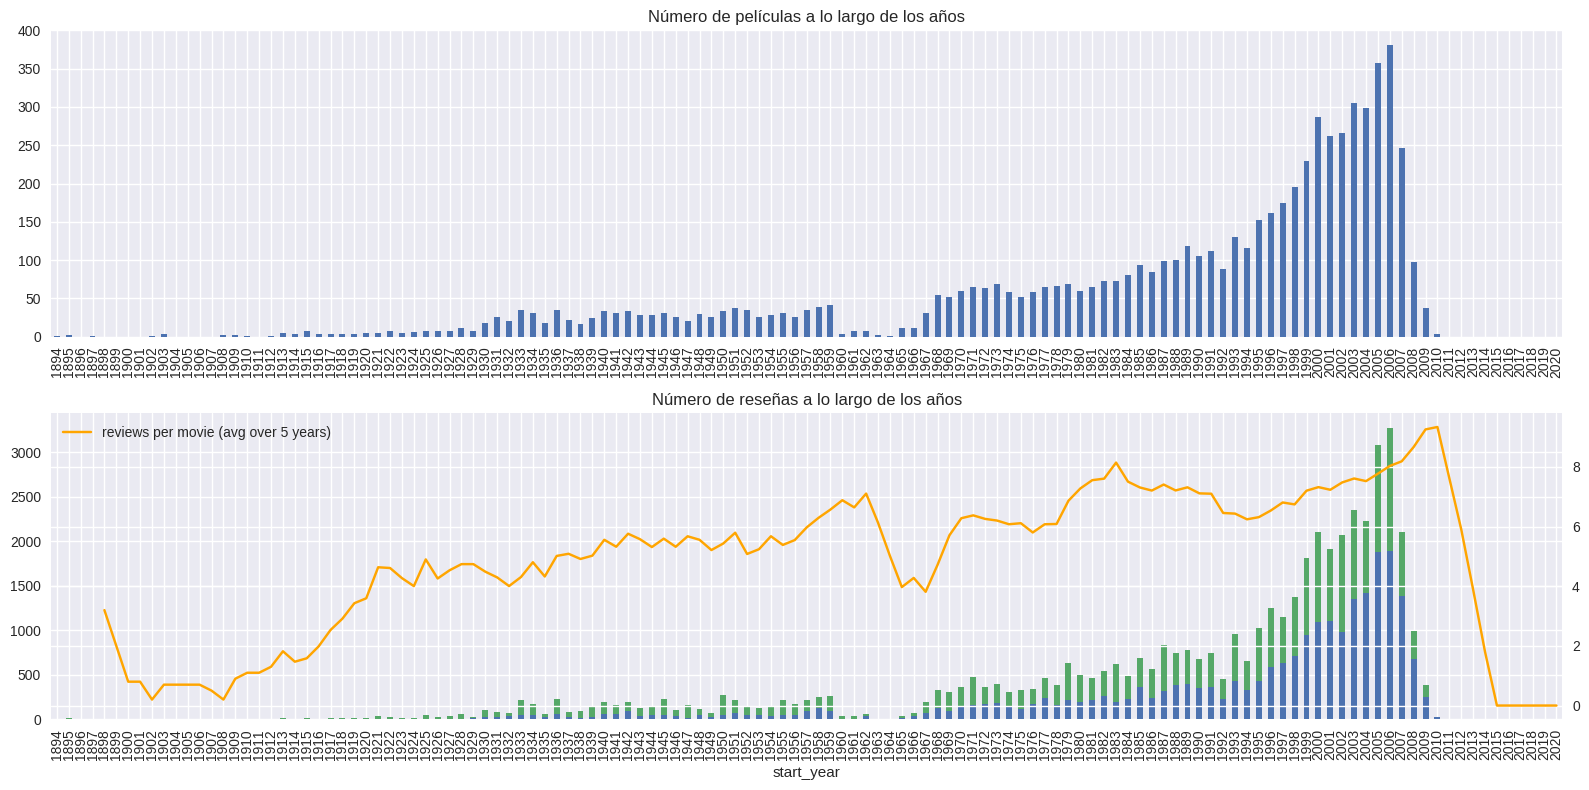

In [89]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

# Plot 1: Number of movies per year
ax = axs[0]

movies_per_year = df_reviews[['tconst', 'start_year']].drop_duplicates()['start_year'] \
    .value_counts().sort_index()
movies_per_year = movies_per_year.reindex(index=np.arange(movies_per_year.index.min(), max(movies_per_year.index.max(), 2021))).fillna(0)

movies_per_year.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over the Years')

# Plot 2: Number of reviews per year (stacked by sentiment)
ax = axs[1]

reviews_by_year_sentiment = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
reviews_by_year_sentiment = reviews_by_year_sentiment.reindex(index=np.arange(reviews_by_year_sentiment.index.min(), max(reviews_by_year_sentiment.index.max(), 2021))).fillna(0)

reviews_by_year_sentiment.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

# Calculate average number of reviews per movie
total_reviews_per_year = df_reviews['start_year'].value_counts().sort_index()
total_reviews_per_year = total_reviews_per_year.reindex(index=np.arange(total_reviews_per_year.index.min(), max(total_reviews_per_year.index.max(), 2021))).fillna(0)

avg_reviews_per_movie = (total_reviews_per_year / movies_per_year).fillna(0)

axt = ax.twinx()
avg_reviews_per_movie.reset_index(drop=True).rolling(5).mean().plot(
    color='orange', label='Reviews per Movie (5-Year Rolling Avg)', ax=axt
)

# Add legend
lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over the Years')

fig.tight_layout()

**Analysis of the Charts:**  
The number of reviews per movie shows a pattern similar to that of movie production by year. As illustrated in the previous charts, there is a steady increase from 1930 to 1959. After that, a decline is observed, which reverses in 1967 when the upward trend resumes. From that point onward, growth continues until it peaks in 2006. After this year, both the number of movies and the number of reviews begin to decline.

Let's look at the distribution of the number of reviews per movie using both the exact count (histogram) and KDE (just to see how it might differ from the exact count):

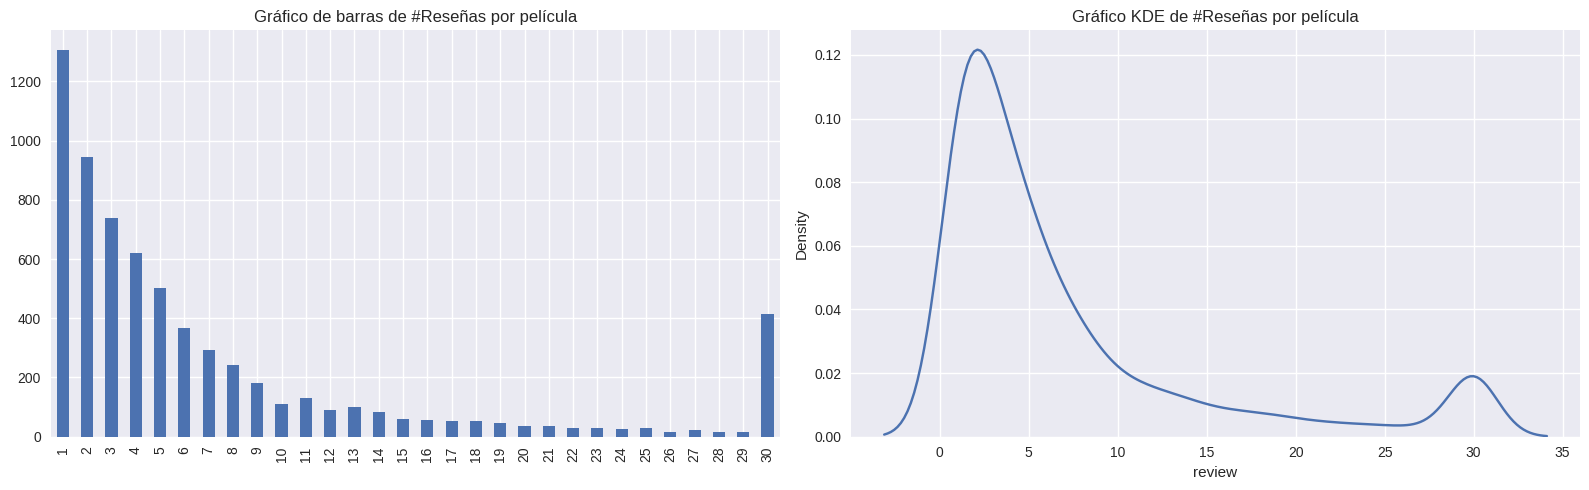

In [90]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Bar chart: Number of reviews per movie
ax = axs[0]
review_counts = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
review_counts.plot.bar(ax=ax)
ax.set_title('Bar Chart of #Reviews per Movie')

# KDE plot: Distribution of review counts
ax = axs[1]
review_counts = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(review_counts, ax=ax)
ax.set_title('KDE Plot of #Reviews per Movie')

fig.tight_layout()

**Analysis of the Charts:**  
Most movies have only one review, and as the number of reviews increases, the number of movies decreases. However, a significant group of movies stands out for having as many as 30 reviews.

In [91]:
df_reviews['pos'].value_counts()

0    23715
1    23614
Name: pos, dtype: int64

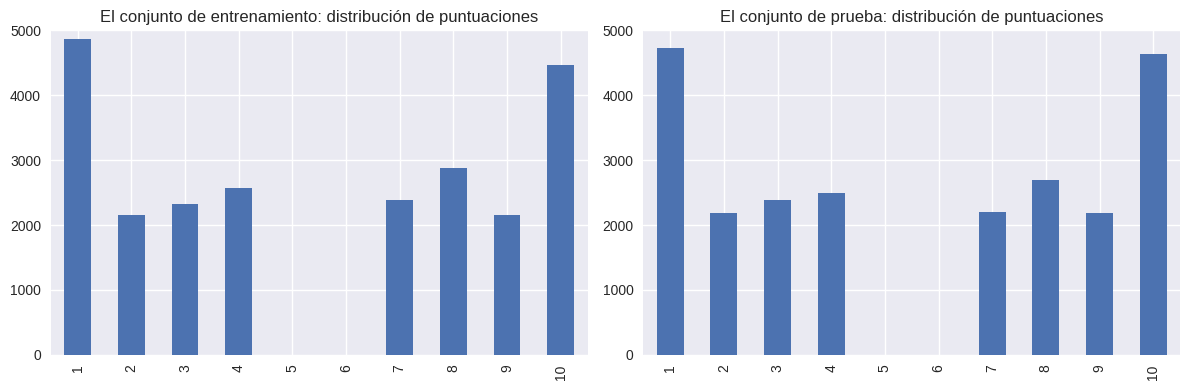

In [92]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot for training set
ax = axs[0]
train_ratings = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
train_ratings = train_ratings.reindex(index=np.arange(min(train_ratings.index.min(), 1), max(train_ratings.index.max(), 11))).fillna(0)
train_ratings.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('Training Set: Rating Distribution')

# Plot for test set
ax = axs[1]
test_ratings = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
test_ratings = test_ratings.reindex(index=np.arange(min(test_ratings.index.min(), 1), max(test_ratings.index.max(), 11))).fillna(0)
test_ratings.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('Test Set: Rating Distribution')

fig.tight_layout()

**Analysis of the Charts:**  
The rating distributions are quite uniform, indicating that there is no imbalance between the classes in the **rating** values.

Distribution of Negative and Positive Reviews Over the Years for Two Parts of the Dataset

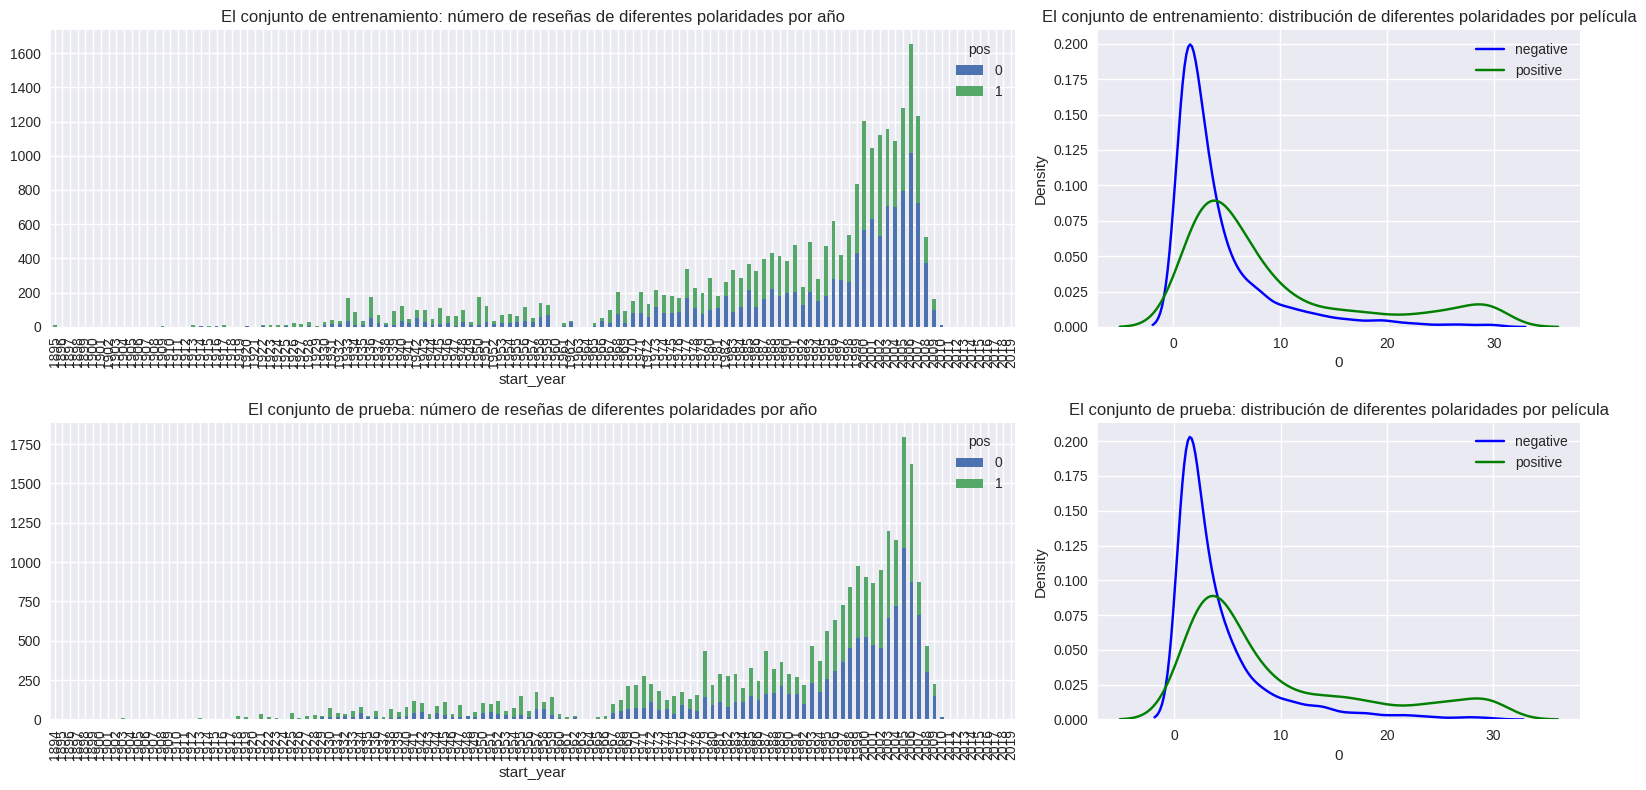

In [93]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

# Plot 1: Training set - number of reviews of different polarities by year
ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Training Set: Number of Reviews of Different Polarities by Year')

# Plot 2: Training set - distribution of different polarities per movie
ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('Training Set: Distribution of Different Polarities per Movie')

# Plot 3: Test set - number of reviews of different polarities by year
ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Test Set: Number of Reviews of Different Polarities by Year')

# Plot 4: Test set - distribution of different polarities per movie
ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('Test Set: Distribution of Different Polarities per Movie')

fig.tight_layout()

**Analysis of the Charts:** The previous charts show similar patterns. In both, it is noticeable that negative reviews are slightly more numerous than positive ones.

## Evaluation Procedure

This function, evaluate_model, evaluates a classification model using key metrics: F1 Score, ROC Curve, Precision-Recall Curve (PRC), and Accuracy. It computes these metrics for both the training and test datasets. The function also generates plots for F1 scores, ROC curve, and PRC, helping to visually assess model performance at different thresholds. It returns a summary of evaluation statistics for both datasets.

In [94]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1 Score
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC Curve
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC (Precision-Recall Curve)
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score Plot
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # Plot thresholds for some values        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC Curve Plot
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # Plot thresholds for some values        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC Plot
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # Plot thresholds for some values        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return 

## Text Normalization

We assume that all models below accept text in lowercase and without digits, punctuation marks, etc.

In [95]:
df_reviews['review_norm'] = df_reviews['review'].apply(lambda x: re.sub("[^a-zA-Z]", " ", x).strip().lower())

## Training and Testing Data Split

Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [96]:
# Splitting the DataFrame into training and testing sets based on 'ds_part' column
df_reviews_train = df_reviews.query('ds_part == "train"').copy()  # Training set
df_reviews_test = df_reviews.query('ds_part == "test"').copy()    # Testing set

# Extracting the target variables (sentiment labels) for both training and testing sets
train_target = df_reviews_train['pos']  # Target for training
test_target = df_reviews_test['pos']    # Target for testing

# Printing the shapes
print(df_reviews_train.shape)  
print(df_reviews_test.shape)   


(23796, 18)
(23533, 18)


## Working with Models

### Model 0 - Constant Model

In [97]:
# Set lemmatizer
lemmatizer = WordNetLemmatizer()

# Set stop words
stop_words = set(stopwords.words('english'))

# Function to lemmatize
def lem_nltk(df_column, lemmatizer, stop_words):
    list = []
    for review in df_column:
        # tokenize
        tokens = word_tokenize(review)
        
        # Remove stop words
        tokens_stop = [token for token in tokens if not token in stop_words]
        
        # Lemmatize tokens without stop words
        lemmas = [lemmatizer.lemmatize(token) for token in tokens_stop]
        lemmas_joined = " ".join(lemmas)
        list.append(lemmas_joined)
        
    return list

In [98]:
# Create features for the training set
train_features0 = lem_nltk(df_reviews_train['review_norm'], lemmatizer, stop_words)

# Create features for the test set
test_features0 = lem_nltk(df_reviews_test['review_norm'], lemmatizer, stop_words)

In [99]:
# Create and train the model
model_0 = DummyClassifier().fit(train_features0, train_target)

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


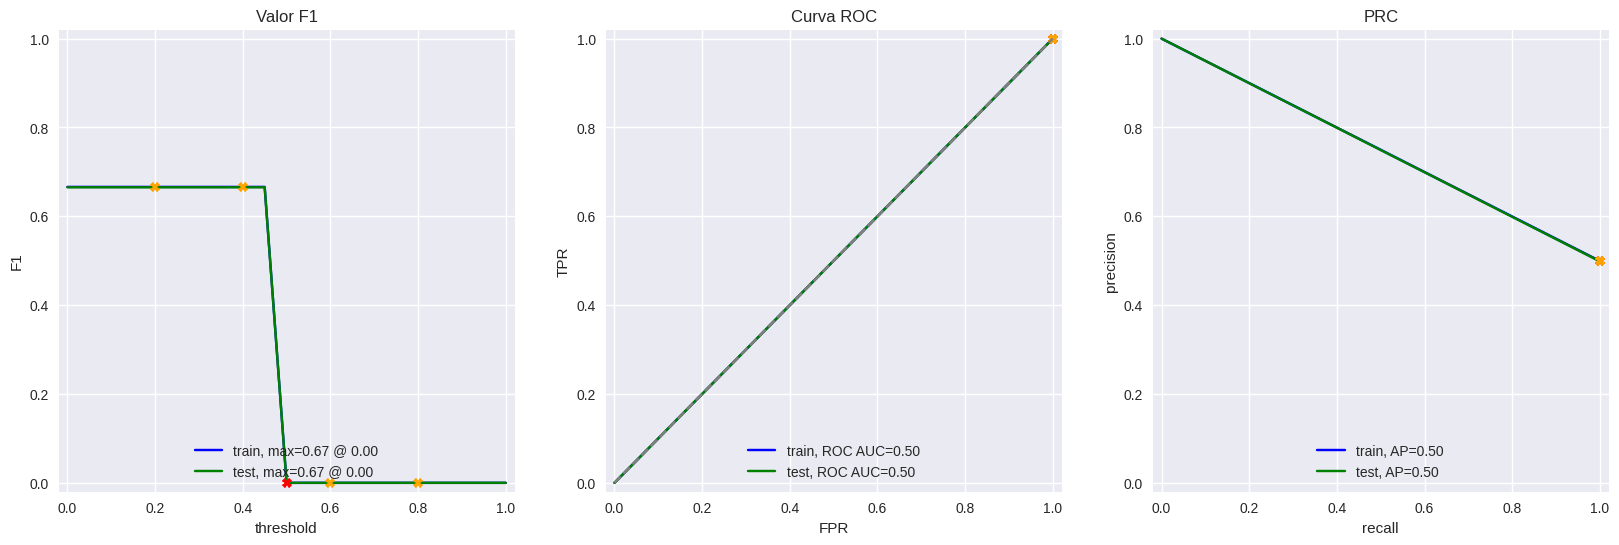

In [100]:
# Evaluate model
evaluate_model(model_0, train_features0, train_target, test_features0, test_target)

**Comments:**  
It makes sense that the F1 score is 0, as this constant model fails to correctly identify cases where `pos` equals 1.  
We hope that the following models will perform better across all metrics.

### Modelo 1 - NLTK, TF-IDF y LR

TF-IDF

In [101]:
# Create features for the training set
count_tf_idf = TfidfVectorizer(stop_words=list(stop_words))
train_features_1 = count_tf_idf.fit_transform(train_features0) 

# Create features for the test set
test_features_1 = count_tf_idf.transform(test_features0) 

# Create and train model
model_1 = LogisticRegression(random_state=12345) 
model_1.fit(train_features_1, train_target)

LogisticRegression(random_state=12345)

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


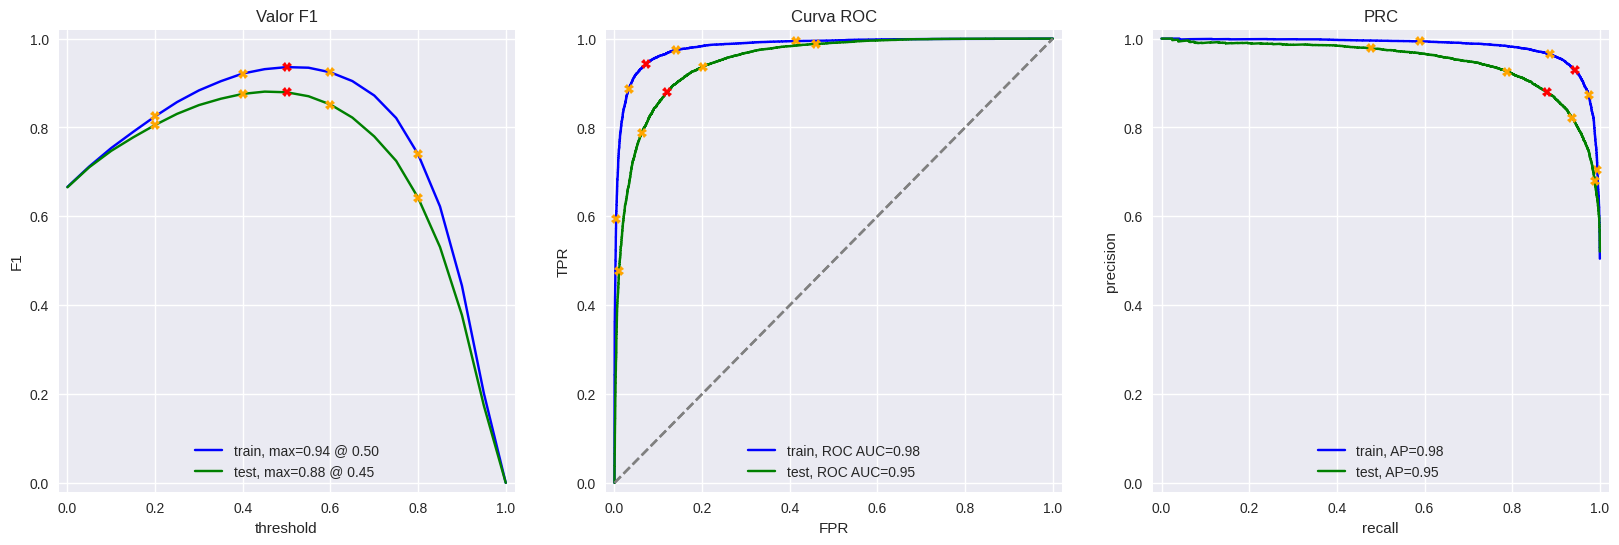

In [102]:
# Evaluate model
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

**Comments:** All metrics outperform those of the dummy model, and the F1 score is above 0.85.

### Modelo 3 - spaCy, TF-IDF y LR

In [103]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [104]:
# Function for lemmatizing with spacy
def lem_spacy(df_column):
    lemmatized_reviews = []
    for review in df_column:
        doc = nlp(review)
        tokens = [token.lemma_ for token in doc if not token.is_stop]
        lemmatized_reviews.append(' '.join(tokens))
    return lemmatized_reviews

In [105]:
# Lemmatize training set
train_spacy2 = lem_spacy(df_reviews_train['review_norm'])
# Lemmatize test set
test_spacy2 = lem_spacy(df_reviews_test['review_norm'])
count_tf_idf_spacy = TfidfVectorizer()

In [106]:
# Features for the training set
train_features_2 = count_tf_idf_spacy.fit_transform(train_spacy2) 
# Features for the test set
test_features_2 = count_tf_idf_spacy.transform(test_spacy2)

In [107]:
# Create the model and train it
model_2 = LogisticRegression(random_state=12345) 
model_2.fit(train_features_2, train_target)

LogisticRegression(random_state=12345)

          train  test
Accuracy   0.93  0.87
F1         0.93  0.87
APS        0.98  0.94
ROC AUC    0.98  0.95


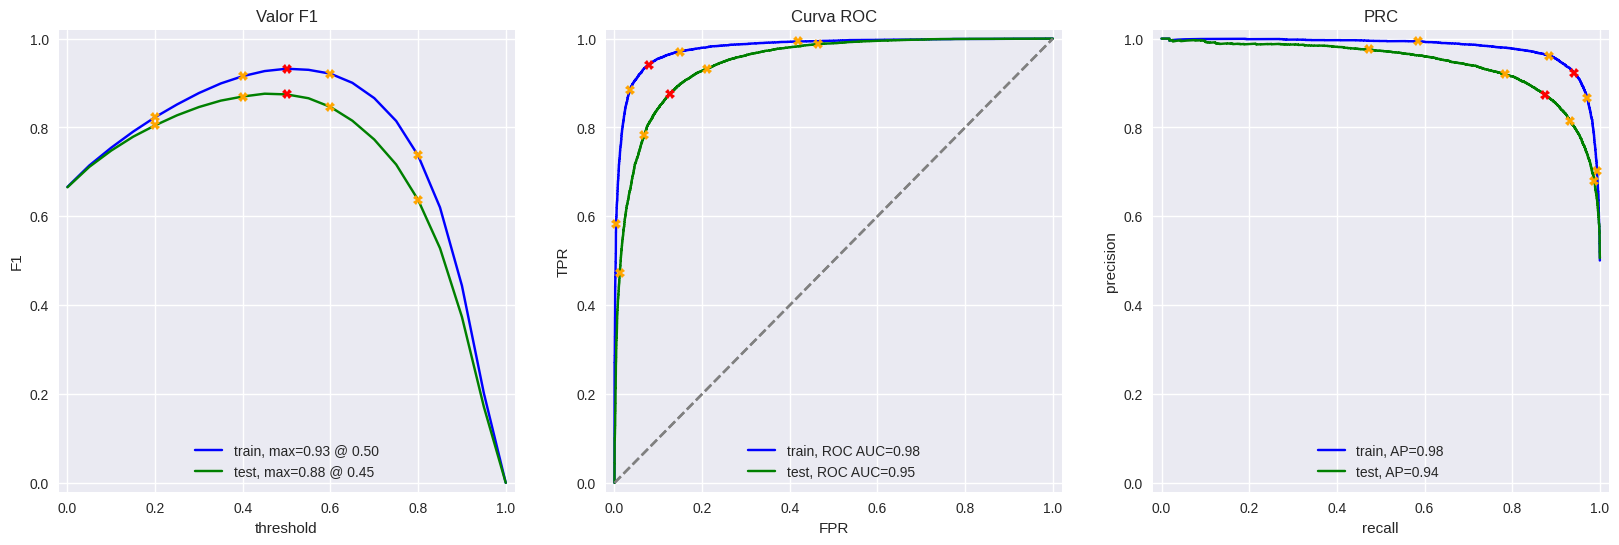

In [113]:
# Evaluate Model
evaluate_model(model_2, train_features_2, train_target, test_features_2, test_target)

**Comments:** The results are high, although the logistic regression model using NLTK still yields better results.

### Modelo 4 - spaCy, TF-IDF y LGBMClassifier con GridSearchCV

In [114]:
# Find best parameters
parameters={'num_leaves':[10, 20], 'learning_rate':[0.5, 0.1], 'n_estimators':[10, 20, 40, 60],
            'objective':['binary'], 'random_state':[12345]}

grid=GridSearchCV(estimator=LGBMClassifier(), param_grid=parameters, scoring='f1', cv=3, n_jobs=-1, verbose=0)
grid.fit(train_features_2, train_target)

GridSearchCV(cv=3, estimator=LGBMClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.5, 0.1],
                         'n_estimators': [10, 20, 40, 60],
                         'num_leaves': [10, 20], 'objective': ['binary'],
                         'random_state': [12345]},
             scoring='f1')

In [115]:
# Create and train model
model_3 = grid.best_estimator_
model_3.fit(train_features_2, train_target)

LGBMClassifier(learning_rate=0.5, n_estimators=60, num_leaves=20,
               objective='binary', random_state=12345)

          train  test
Accuracy   0.94  0.85
F1         0.94  0.85
APS        0.99  0.93
ROC AUC    0.99  0.93


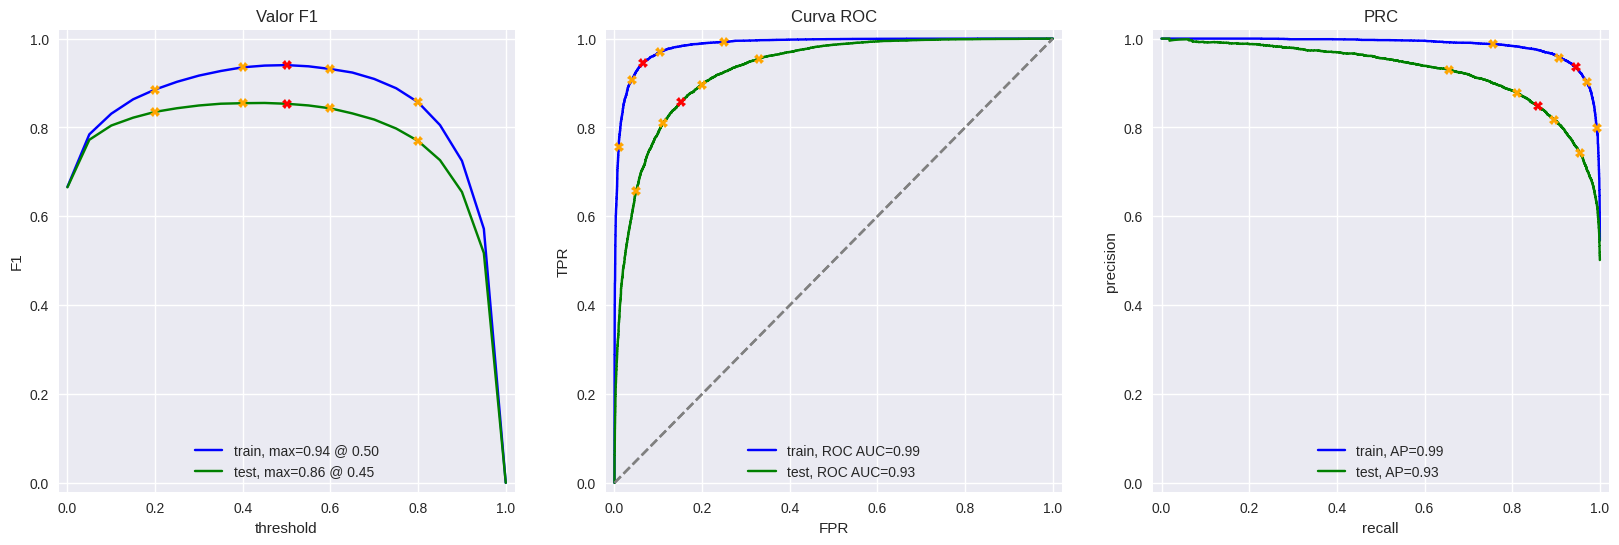

In [116]:
# Evaluate Model
evaluate_model(model_3, train_features_2, train_target, test_features_2, test_target)

**Comments:** The logistic regression model using NLTK continues to produce better results in the trained models.

## My Reviews 

In [7]:
# Reviews 

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

# Normalization: Convert text to lowercase, retain only alphabetic characters, and remove extra whitespace using strip()
my_reviews['review_norm'] = my_reviews['review'].apply(lambda x: re.sub("[^a-zA-Z]", " ", x).strip().lower())

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middl...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didn t expect the reboot to be so good writ...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a singl...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i real...


**Comments:** The `my_reviews` DataFrame contains 8 reviews:

- Reviews 0, 1, 3, and 6 are **negative**.
- Reviews 2, 4, 5, and 7 are **positive**.

However, review 6 is more of a "somewhat positive" one. The author describes it as "decent" and mentions that "I could watch it again," but also points out some "negative aspects."

It wouldn't be surprising if the models have difficulty correctly classifying review 6.

### Model 1

In [126]:
# Extract normalized reviews from the 'my_reviews' DataFrame
texts = my_reviews['review_norm']

# Predict probabilities for the positive class using model_1 and TF-IDF transformed data
my_reviews_pred_prob = model_1.predict_proba(count_tf_idf.transform(texts))[:, 1]

# Iterate through the first 100 characters of each review and print the predicted probability
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.15:  i did not simply like it  not my kind of movie
0.16:  well  i was bored and felt asleep in the middle of the movie
0.55:  i was really fascinated with the movie
0.13:  even the actors looked really old and disinterested  and they got paid to be in the movie  what a so
0.35:  i didn t expect the reboot to be so good  writers really cared about the source material
0.47:  the movie had its upsides and downsides  but i feel like overall it s a decent flick  i could see my
0.03:  what a rotten attempt at a comedy  not a single joke lands  everyone acts annoying and loud  even ki
0.88:  launching on netflix was a brave move   i really appreciate being able to binge on episode after epi


**Results:** Review number 4 was labeled as negative, although it is actually positive. The same happened with review number 5, which is very close to being classified as positive, but the content is not entirely favorable.

### Model 2

In [127]:
# Lemmatize the normalized reviews using SpaCy
my_rev_spacy = lem_spacy(my_reviews['review_norm'])

# Predict probabilities for the positive class using model_2 and TF-IDF transformed data (SpaCy lemmatized)
my_reviews_pred_prob = model_2.predict_proba(count_tf_idf_spacy.transform(my_rev_spacy))[:, 1]

# Iterate through the first 100 characters of each review and print the predicted probability
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.19:  i did not simply like it  not my kind of movie
0.08:  well  i was bored and felt asleep in the middle of the movie
0.50:  i was really fascinated with the movie
0.15:  even the actors looked really old and disinterested  and they got paid to be in the movie  what a so
0.19:  i didn t expect the reboot to be so good  writers really cared about the source material
0.41:  the movie had its upsides and downsides  but i feel like overall it s a decent flick  i could see my
0.03:  what a rotten attempt at a comedy  not a single joke lands  everyone acts annoying and loud  even ki
0.91:  launching on netflix was a brave move   i really appreciate being able to binge on episode after epi


**Results:** Review number 4 was labeled as negative, although it is actually positive. The same happened with review number 5, which is very close to being classified as positive, but the content is not entirely favorable.

### Model 3

In [128]:
# Predict probabilities for the positive class using model_3 and TF-IDF transformed data (SpaCy lemmatized)
my_reviews_pred_prob = model_3.predict_proba(count_tf_idf_spacy.transform(my_rev_spacy))[:, 1]

# Iterate through the first 100 characters of each review and print the predicted probability
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.54:  i did not simply like it  not my kind of movie
0.23:  well  i was bored and felt asleep in the middle of the movie
0.55:  i was really fascinated with the movie
0.36:  even the actors looked really old and disinterested  and they got paid to be in the movie  what a so
0.65:  i didn t expect the reboot to be so good  writers really cared about the source material
0.53:  the movie had its upsides and downsides  but i feel like overall it s a decent flick  i could see my
0.23:  what a rotten attempt at a comedy  not a single joke lands  everyone acts annoying and loud  even ki
0.91:  launching on netflix was a brave move   i really appreciate being able to binge on episode after epi


**Results:** The review with index 0 was marked as positive, but it is actually negative. This could indicate a failure in the classification system, as the content clearly reflects an unfavorable experience. It would be advisable to analyze this case in detail to adjust the model and improve its accuracy.

## Conclusions

Except for **Model 0**, which was created as a Dummy model to use as a reference, all other models showed pretty good results, with F1 metrics of at least 0.85, which is acceptable.

The one with the best performance was **Model 1**, which is a **logistic regression** model. This model uses:
- The **NLTK** library to split the text into words (tokenization) and reduce them to their base form (lemmatization).
- **TF-IDF** values as features to analyze the text.

In summary, **Model 1** was the most effective compared to the others.

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


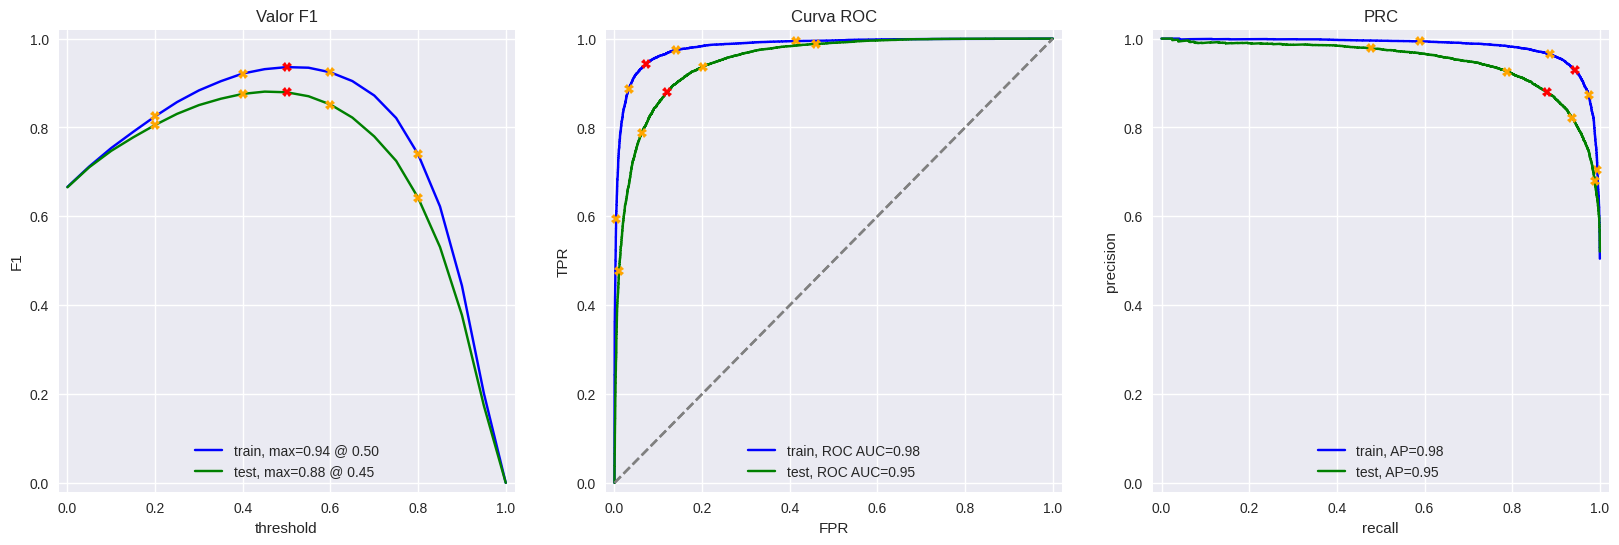

In [129]:
# Evaluate the recommended model on both train and test datasets
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

The goal of the **Film Junky Union** project was to create a model capable of automatically classifying IMDB movie reviews as positive or negative, with a target F1 score of at least 0.85 on the test set. The model not only met this target but exceeded it, achieving an impressive F1 score of 0.88 on the test set. Along with this, key performance metrics such as **Accuracy**, **APS**, and **ROC AUC** also reached high values, confirming the model's strength and reliability.

In short, the model successfully fulfilled all project requirements and is now fully equipped to support **Film Junky Union** in automating the classification of reviews. This will significantly enhance user experience on their platform, helping users find the reviews that matter most to them with ease.